## IMPLEMENT GAN WITH TF.SLIM

In [1]:
import time
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
print ("TENSORFLOW VERSION IS %s" % (tf.__version__))

TENSORFLOW VERSION IS 1.0.1


## TO SHORTEN THE CODE

In [2]:
tf_tni  = tf.truncated_normal_initializer
tf_rni  = tf.random_normal_initializer
tf_ci   = tf.constant_initializer
slim_fc = slim.fully_connected
slim_bn = slim.batch_norm
slim_ct = slim.conv2d_transpose
slim_c  = slim.conv2d
tf_relu = tf.nn.relu
tf_tanh = tf.nn.tanh
tf_sigm = tf.nn.sigmoid
tf_sigce = tf.nn.sigmoid_cross_entropy_with_logits

## UTILS

In [3]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 1))
    for idx, image in enumerate(images):
        image = image.reshape(28, 28)
        i = idx % size[1]
        j = idx // size[1]        
        img[j*h:j*h+h, i*w:i*w+w, 0] = image
    return img

## MAKE DCGAN CLASS

In [4]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)
    
class DCGAN(object):
    def __init__(self, sess):
        self.sess = sess
        self.batch_size  = 64
        self.image_size  = 28
        self.sample_size = 64
        self.c_dim       = 1
        self.z_dim       = 100
        self.gf_dim      = 64 
        self.df_dim      = 64
        # INITIALIZE PARAMETERS
        self.conv_init_params  = tf_tni(stddev=0.02)
        self.fully_init_params = tf_rni(stddev=0.02)
        self.bias_init_params  = tf_ci(0.0)
        self.bn_init_params    = {'beta': tf_ci(0.), 'gamma': tf_rni(1., 0.02)}
        # BUILD MODEL
        self.build_model()
    
    def generator(self, z, is_training=True):
        bn_params = {'is_training': is_training, 'decay': 0.9, 'epsilon': 1e-5
                     , 'param_initializers': self.bn_init_params
                     , 'updates_collections': None}
        s, s4 = self.image_size, int(self.image_size/4)
        with tf.variable_scope('G') as scope:
            z = slim_fc(z, self.gf_dim*2*s4*s4, activation_fn = None
                        , weights_initializer = self.fully_init_params
                        , biases_initializer = self.bias_init_params, scope = 'lin0')
            d0 = tf.reshape(z, [self.batch_size, s4, s4, self.gf_dim*2])
            d0 = slim_bn(d0, decay=0.9, param_initializers = self.bn_init_params
                         , activation_fn = tf.nn.relu, scope = 'lin1')
            d1 = slim_ct(d0, self.gf_dim*1, [5, 5], stride = 2, activation_fn = tf_relu
                         , weights_initializer = self.conv_init_params
                         , biases_initializer = self.bias_init_params
                         , normalizer_fn = slim.batch_norm
                         , normalizer_params = bn_params, scope = 'dconv1')
            gen = slim_ct(d1, self.c_dim, [5, 5], stride = 2, activation_fn = tf_sigm
                          ,weights_initializer = self.conv_init_params
                          , biases_initializer = self.bias_init_params, scope = 'dconv2')
        return gen
    
    def discriminator(self, image, is_training=True, reuse=False):
        bn_params = {'is_training': is_training, 'decay': 0.9, 'epsilon': 1e-5
                     , 'param_initializers': self.bn_init_params
                     , 'updates_collections': None}
        with tf.variable_scope('D') as scope:
            if reuse:
                scope.reuse_variables()
            e0 = slim_c(image, self.df_dim, [5, 5], stride = 2, activation_fn = lrelu
                        , weights_initializer = self.conv_init_params
                        , biases_initializer = self.bias_init_params, scope='conv0')
            e1 = slim_c(e0, self.df_dim*2, [5, 5], stride = 2, activation_fn = lrelu
                        , weights_initializer = self.conv_init_params
                        , biases_initializer = self.bias_init_params
                        , normalizer_fn = slim_bn, normalizer_params = bn_params, scope='conv1')
            e2 = slim_fc(tf.reshape(e1, [self.batch_size, -1]), 1, activation_fn=None
                         , weights_initializer = self.fully_init_params
                         , biases_initializer = self.bias_init_params, scope='lin2')
        return tf.nn.sigmoid(e2), e2
    
    def build_model(self):
        # PLACE HOLDERS
        _shape = [self.batch_size] + [self.image_size, self.image_size, self.c_dim]
        self.images = tf.placeholder(tf.float32, _shape)
        self.z = tf.placeholder(tf.float32, [None, self.z_dim])
        self.is_training = tf.placeholder(tf.bool)
        # GENERATOR
        self.G = self.generator(self.z, self.is_training)
        # DISCRIMINATOR
        d_real, d_real_logits = self.discriminator(self.images, self.is_training, reuse=False)
        d_gen, d_gen_logits = self.discriminator(self.G, self.is_training, reuse=True)
        # LOSS
        self.d_loss = tf.reduce_mean(tf_sigce(logits=d_real_logits, labels=tf.ones_like(d_real))) \
                        + tf.reduce_mean(tf_sigce(logits=d_gen_logits, labels=tf.zeros_like(d_gen)))
        self.g_loss = tf.reduce_mean(tf_sigce(logits=d_gen_logits, labels=tf.ones_like(d_gen)))
        # GET VARIABLES
        t_vars = tf.trainable_variables()
        self.g_vars = [var for var in t_vars if 'G/' in var.name]
        self.d_vars = [var for var in t_vars if 'D/' in var.name]
        print ("BUILD MODEL")
    
    def train(self, config):
        print ("START TRAINING.")
        # LOAD 
        np.random.seed(0)
        mnist = input_data.read_data_sets('data/', one_hot=True)
        trX = mnist.train.images.reshape([-1, 28, 28, 1])
        teX = mnist.test.images.reshape([-1, 28, 28, 1])
        data = np.concatenate((trX, teX), axis=0)
        np.random.shuffle(data)
        # SET OPTIMIZERS
        adam = tf.train.AdamOptimizer(config.learning_rate, beta1=config.beta1)
        g_optim = adam.minimize(self.g_loss, var_list=self.g_vars)
        d_optim = adam.minimize(self.d_loss, var_list=self.d_vars)
        # INITIALIZE
        init = tf.global_variables_initializer()
        self.sess.run(init)
        # generate fixed sample seed: batch_size * z_dim
        sample_z = np.random.uniform(-1, 1, size=(self.batch_size, self.z_dim))
        # prepare sample images
        sample_images = data[0:self.batch_size]
        
        # PLOT REFERENCE IMAGES
        img_merged = merge(sample_images[0:self.sample_size], [8, 8])
        plt.imshow(img_merged[:, :, 0], cmap='gray')
        plt.title('Reference Image')
        plt.show()
    
        start_time = time.time()
        for epoch in xrange(config.epoch):
            np.random.seed(epoch)
            np.random.shuffle(data)
            batch_idxs = min(len(data), config.train_size) // config.batch_size
            for idx in xrange(0, batch_idxs):
                # GET BATCH IMAGES
                batch_images = data[xrange(idx * config.batch_size,(idx + 1) * config.batch_size)]
                # GENERATE RANDOM VECTOR Z
                z_size = [config.batch_size, self.z_dim]
                batch_z = np.random.uniform(-1, 1, z_size).astype(np.float32)
                # UPDATE D AND G
                feeds = {self.images: batch_images, self.z: batch_z, self.is_training: True}
                _, _ = self.sess.run([d_optim, g_optim], feed_dict=feeds)
                # GET G AND D LOSS
                g_loss, d_loss = self.sess.run([self.g_loss, self.d_loss], feed_dict=feeds)
                # PRINT
                if (idx % 200) == 0:
                    print("Epoch: [%2d] [%4d/%4d] time: %5.2fs, d: %.5f, g: %.5f" 
                          % (epoch, idx, batch_idxs, time.time()-start_time, d_loss, g_loss))

            # PLOT EVERY EPOCH 
            feeds = {self.z: sample_z, self.is_training: False}
            sG = self.sess.run([self.G], feed_dict=feeds)
            concatIm = np.concatenate(sG)
            img_merged = merge(concatIm, [8, 8])
            plt.imshow(img_merged[:, :, 0], cmap='gray')
            plt.colorbar()
            plt.title('Sampled Images (Epoch:' + str(epoch) + ')')
            plt.show()

## DCGAN

In [5]:
sess  = tf.Session()
dcgan = DCGAN(sess)
print ("DCGAN READY")

BUILD MODEL
DCGAN READY


## TRAIN

START TRAINING.
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


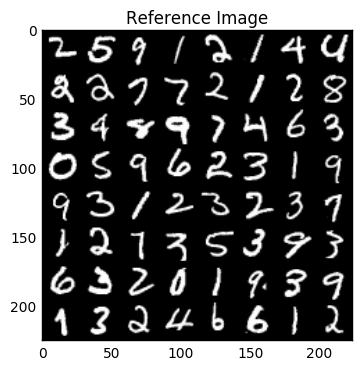

Epoch: [ 0] [   0/1015] time:  0.50s, d: 0.39614, g: 1.89015
Epoch: [ 0] [ 200/1015] time:  3.37s, d: 0.05870, g: 3.71089
Epoch: [ 0] [ 400/1015] time:  6.21s, d: 0.18181, g: 2.74143
Epoch: [ 0] [ 600/1015] time:  9.04s, d: 0.51333, g: 2.53121
Epoch: [ 0] [ 800/1015] time: 11.88s, d: 1.05126, g: 0.65942
Epoch: [ 0] [1000/1015] time: 14.70s, d: 0.45937, g: 2.20037


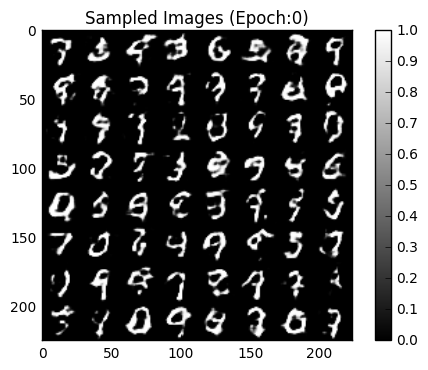

Epoch: [ 1] [   0/1015] time: 15.17s, d: 0.77931, g: 0.85933
Epoch: [ 1] [ 200/1015] time: 17.99s, d: 0.60612, g: 2.96121
Epoch: [ 1] [ 400/1015] time: 20.82s, d: 0.43347, g: 1.81676
Epoch: [ 1] [ 600/1015] time: 23.66s, d: 1.01741, g: 0.63041
Epoch: [ 1] [ 800/1015] time: 26.50s, d: 0.86064, g: 2.16909
Epoch: [ 1] [1000/1015] time: 29.33s, d: 1.08012, g: 0.66806


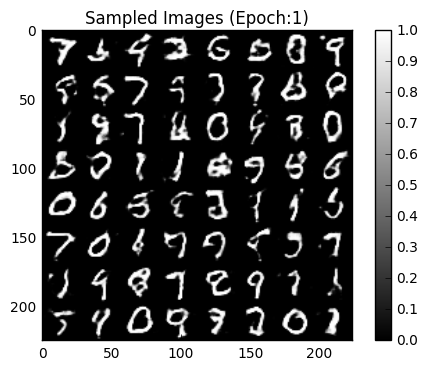

Epoch: [ 2] [   0/1015] time: 29.84s, d: 0.69420, g: 2.69148
Epoch: [ 2] [ 200/1015] time: 32.68s, d: 1.07021, g: 0.61912
Epoch: [ 2] [ 400/1015] time: 35.52s, d: 0.69923, g: 1.15599
Epoch: [ 2] [ 600/1015] time: 38.36s, d: 0.64110, g: 1.21664
Epoch: [ 2] [ 800/1015] time: 41.19s, d: 1.06842, g: 0.67734
Epoch: [ 2] [1000/1015] time: 44.06s, d: 1.14418, g: 2.86002


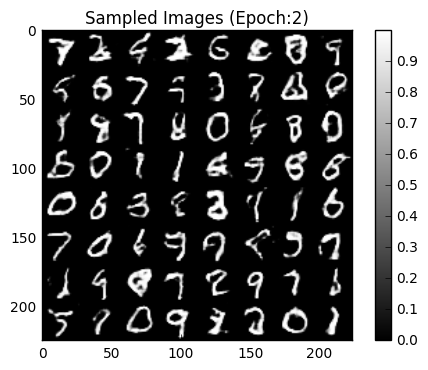

Epoch: [ 3] [   0/1015] time: 44.51s, d: 0.68899, g: 1.02008
Epoch: [ 3] [ 200/1015] time: 47.34s, d: 0.85266, g: 0.89082
Epoch: [ 3] [ 400/1015] time: 50.17s, d: 0.66169, g: 1.29461
Epoch: [ 3] [ 600/1015] time: 53.00s, d: 0.66240, g: 1.26759
Epoch: [ 3] [ 800/1015] time: 55.83s, d: 0.65193, g: 1.35488
Epoch: [ 3] [1000/1015] time: 58.66s, d: 0.66695, g: 1.34818


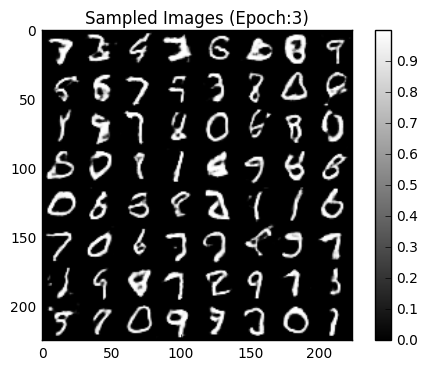

Epoch: [ 4] [   0/1015] time: 59.11s, d: 0.82507, g: 0.88899
Epoch: [ 4] [ 200/1015] time: 61.94s, d: 0.99423, g: 0.73103
Epoch: [ 4] [ 400/1015] time: 64.84s, d: 0.66873, g: 2.59559
Epoch: [ 4] [ 600/1015] time: 67.75s, d: 0.68511, g: 1.27615
Epoch: [ 4] [ 800/1015] time: 70.67s, d: 0.67924, g: 2.32815
Epoch: [ 4] [1000/1015] time: 73.64s, d: 0.83588, g: 0.78320


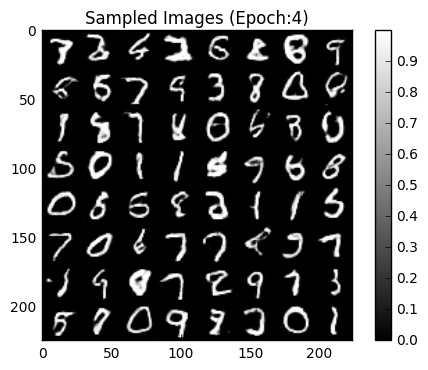

Epoch: [ 5] [   0/1015] time: 74.11s, d: 0.83745, g: 0.90068
Epoch: [ 5] [ 200/1015] time: 77.01s, d: 0.72836, g: 1.38654
Epoch: [ 5] [ 400/1015] time: 79.95s, d: 0.66265, g: 1.58842
Epoch: [ 5] [ 600/1015] time: 82.89s, d: 0.65923, g: 1.31927
Epoch: [ 5] [ 800/1015] time: 85.86s, d: 0.67121, g: 1.23946
Epoch: [ 5] [1000/1015] time: 88.80s, d: 0.88158, g: 0.77445


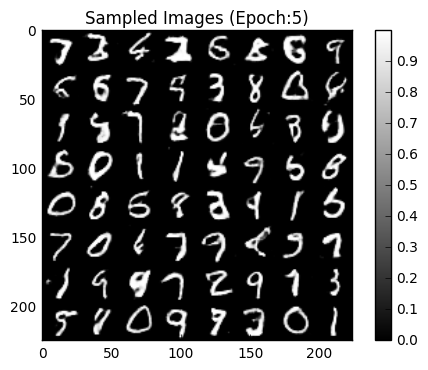

Epoch: [ 6] [   0/1015] time: 89.26s, d: 0.88850, g: 0.80548
Epoch: [ 6] [ 200/1015] time: 92.14s, d: 0.77683, g: 1.04363
Epoch: [ 6] [ 400/1015] time: 95.17s, d: 0.71324, g: 1.26831
Epoch: [ 6] [ 600/1015] time: 98.15s, d: 0.61891, g: 1.33171
Epoch: [ 6] [ 800/1015] time: 101.14s, d: 0.71236, g: 1.10356
Epoch: [ 6] [1000/1015] time: 104.10s, d: 0.69531, g: 1.12220


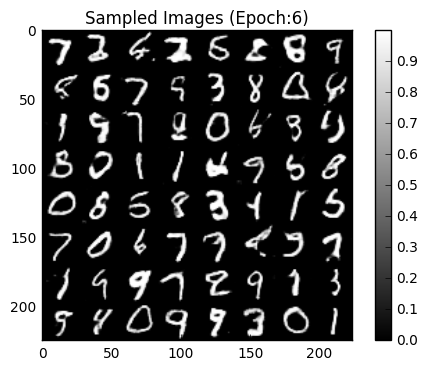

Epoch: [ 7] [   0/1015] time: 104.57s, d: 0.69724, g: 1.25731
Epoch: [ 7] [ 200/1015] time: 107.67s, d: 0.70655, g: 1.16797
Epoch: [ 7] [ 400/1015] time: 110.56s, d: 0.60255, g: 1.64237
Epoch: [ 7] [ 600/1015] time: 113.55s, d: 1.19699, g: 0.59083
Epoch: [ 7] [ 800/1015] time: 116.51s, d: 0.72387, g: 1.06283
Epoch: [ 7] [1000/1015] time: 119.42s, d: 0.58729, g: 1.39843


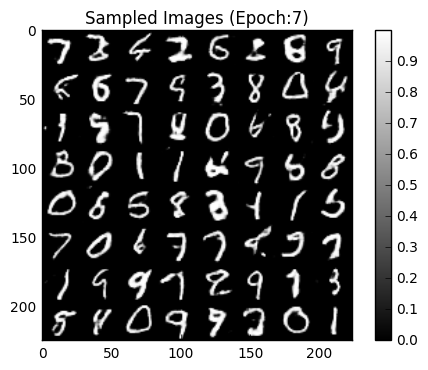

Epoch: [ 8] [   0/1015] time: 119.89s, d: 0.58067, g: 1.33711
Epoch: [ 8] [ 200/1015] time: 122.85s, d: 0.53217, g: 2.01251
Epoch: [ 8] [ 400/1015] time: 125.81s, d: 0.64057, g: 1.55116
Epoch: [ 8] [ 600/1015] time: 128.76s, d: 0.72704, g: 1.27213
Epoch: [ 8] [ 800/1015] time: 131.74s, d: 0.75827, g: 1.02436
Epoch: [ 8] [1000/1015] time: 134.67s, d: 0.55178, g: 1.32770


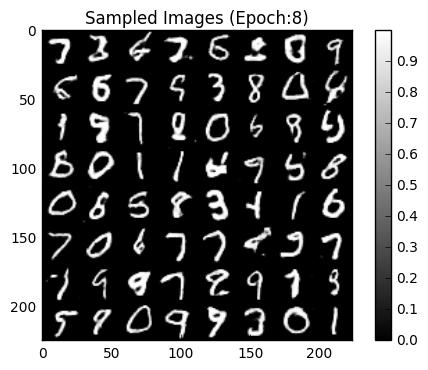

Epoch: [ 9] [   0/1015] time: 135.12s, d: 0.57390, g: 1.27284
Epoch: [ 9] [ 200/1015] time: 138.08s, d: 0.94893, g: 0.80698
Epoch: [ 9] [ 400/1015] time: 141.05s, d: 0.92146, g: 0.76999
Epoch: [ 9] [ 600/1015] time: 143.98s, d: 1.25501, g: 0.51201
Epoch: [ 9] [ 800/1015] time: 146.99s, d: 1.17342, g: 0.59463
Epoch: [ 9] [1000/1015] time: 149.93s, d: 0.63691, g: 1.18345


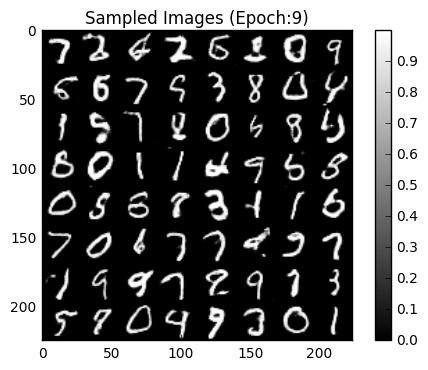

In [6]:
flags = tf.app.flags
flags.DEFINE_integer("epoch",         10,      "Epochs")
flags.DEFINE_float(  "learning_rate", 0.0002,  "Learning Rate")
flags.DEFINE_float(  "beta1",         0.5,     "Momentum")
flags.DEFINE_integer("train_size",    np.inf,  "Maximum Train Size")
flags.DEFINE_integer("batch_size",    64,      "Batch Size")
flags.DEFINE_integer("c_dim",         1,       "Channel")
FLAGS = flags.FLAGS

dcgan.train(FLAGS)